# Project - Recommendation Systems - AIML - Aishik Sengupta


--------------


## <b><u>Data Description</u></b> :
Amazon Reviews data (data source) The repository has several datasets. For this case study, we are using the Electronics dataset.



## <b><u>Domain</u></b> :
E-commerce



## <b><u>Context</u></b> :
Online E-commerce websites like Amazon, Flipkart uses different recommendation models to provide different suggestions to different users. Amazon currently uses item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.


## <b><u>Attribute Information</u></b> :

<ul>
    <li>userId : Every user identified with a unique id</li>
    <li>productId : Every product identified with a unique id</li>
    <li>Rating : Rating of the corresponding product by the corresponding user</li>
    <li>timestamp : Time of the rating ( ignore this column for this exercise)</li>
</ul>




## <b><u>Learning Outcomes</u></b>:

<ul>
    <li>Exploratory Data Analysis</li>
    <li>Creating a Recommendation system using real data</li>
    <li>Collaborative filtering</li>
</ul>


## <b><u>Objective</u></b> :

Build a recommendation system to recommend products to customers based on the their previous ratings for other products.



## <b><u>Steps and tasks</u></b>:

<ol>
    <li>Read and explore the given dataset. (Rename column/add headers, plot histograms, find data characteristics) - (3 Marks)
    </li>
    <li>Take a subset of the dataset to make it less sparse/ denser. ( For example, keep the users only who has given 50 or more number of ratings ) - (3 Marks)
    </li>
    <li>Split the data randomly into train and test dataset. ( For example, split it in 70/30 ratio) - (3 Marks)
    </li>
    <li>Build Popularity Recommender model. - (20 Marks)
    </li>
    <li>Build Collaborative Filtering model. - (20 Marks)
    </li>
    <li>Evaluate both the models. ( Once the model is trained on the training data, it can be used to compute the error (RMSE) on predictions made on the test data.) - (7 Marks)
    </li>
    <li>Get top - K ( K = 5) recommendations. Since our goal is to recommend new products for each user based on his/her habits, we will recommend 5 new products. - (7 Marks)
    </li>
    <li>Summarise your insights. - (7 Marks)
    </li>
</ol>
<br>
<br>
<br>
<br>
<br>


In [27]:
import numpy as np
import pandas as pd
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.externals import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

from numpy import array
from numpy import diag
from numpy import dot
from scipy.linalg import svd
from scipy.sparse.linalg import svds

from surprise import SVD
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import train_test_split

In [28]:
ratings = pd.read_csv('ratings_Electronics.csv', header=None)

In [29]:
ratings.shape # dimensions of the dataset

(7824482, 4)

In [30]:
ratings.head()

,0,1,2,3
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [31]:
ratings.columns = ['userId','productId','Rating','timestamp'] # adding the columns

In [32]:
ratings.head()

,userId,productId,Rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [33]:
ratings.drop('timestamp', axis=1, inplace=True) # no need of timestamp for this assignment

In [34]:
ratings.dtypes # datatypes of columns

userId        object
productId     object
Rating       float64
dtype: object

In [35]:
ratings.isnull().sum() # there is no null value

userId       0
productId    0
Rating       0
dtype: int64

In [36]:
ratings.describe().T

,count,mean,std,min,25%,50%,75%,max
Rating,7824482.0,4.012337,1.38091,1.0,3.0,5.0,5.0,5.0


Atleast 50% of the users ratings are having highest rating with atleast 75% of user ratings having a rating of 3.
The mean rating of a little over 4 indicates the high quality range of products that is being sold to customers in Amazon.

In [37]:
print(f'The minimum rating is {ratings.Rating.min()}')
print(f'The maximum rating is {ratings.Rating.max()}')

The minimum rating is 1.0
The maximum rating is 5.0


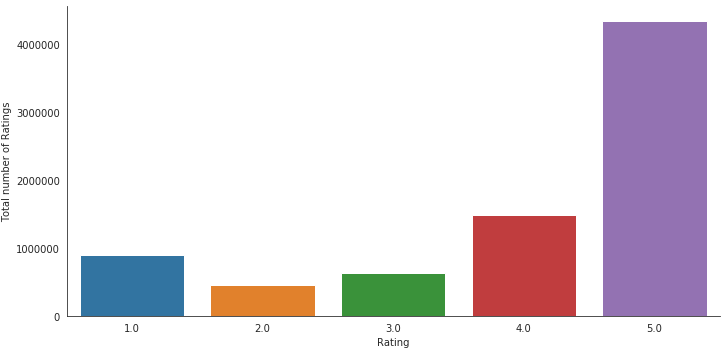

In [38]:
with sns.axes_style('white'):
    g = sns.catplot("Rating", data = ratings , aspect = 2.0 , kind = 'count')
    g.set_ylabels("Total number of Ratings")

Therefore the descending order of frequency of ratings given is 5,4,1,3,2.

In [39]:
print(f'The number of unique users are {ratings.userId.nunique()}')
print(f'The number of unique items are {ratings.productId.nunique()}')

The number of unique users are 4201696
The number of unique items are 476002


In [40]:
counts = ratings.userId.value_counts()
counts # ratings given per user

A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
                 ... 
A12OI3CG2HLKM8      1
A3LKUQX3OZSAK7      1
ACJBVZNYNPNY2       1
AGHDAVAKL809U       1
A3LNKRE5EG7M5M      1
Name: userId, Length: 4201696, dtype: int64

In [41]:
#capturing a subset of the data where users have rated atleast 50 items
ratings_50 = ratings[ratings.userId.isin(counts[counts>=50].index)]

In [42]:
print(f'Number of users who have rated fifty or more items = {len(ratings_50)}' )
print(f'The number of unique users who have rated atleast fifty items = {ratings_50.userId.nunique()}')
print(f'The number of unique items whose users have rated atleast fifty items = {ratings_50.productId.nunique()}')

Number of users who have rated fifty or more items = 125871
The number of unique users who have rated atleast fifty items = 1540
The number of unique items whose users have rated atleast fifty items = 48190


In [43]:
ratings_50

,userId,productId,Rating
94,A3BY5KCNQZXV5U,0594451647,5.0
118,AT09WGFUM934H,0594481813,3.0
177,A32HSNCNPRUMTR,0970407998,1.0
178,A17HMM1M7T9PJ1,0970407998,4.0
492,A3CLWR1UUZT6TG,0972683275,5.0
...,...,...,...
7824426,A1E1LEVQ9VQNK,B00LGQ6HL8,5.0
7824427,A2NYK9KWFMJV4Y,B00LGQ6HL8,5.0
7824436,A3AYSYSLHU26U9,B00LI4ZZO8,4.0
7824438,A2NYK9KWFMJV4Y,B00LI4ZZO8,5.0


<br>

In [44]:
# using sklearn training and testing split
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(ratings_50, test_size = 0.30 , random_state = 0)

In [45]:
train_data

,userId,productId,Rating
6595853,A2BYV7S1QP2YIG,B009EAHVTA,5.0
4738241,AB094YABX21WQ,B0056XCEAA,1.0
4175596,A3D0UM4ZD2CMAW,B004I763AW,5.0
3753016,AATWFX0ZZSE6C,B0040NPHMO,3.0
1734767,A1NNMOD9H36Q8E,B0015VW3BM,4.0
...,...,...,...
2592347,A3QRW0UJPKIAX7,B002GYPS3M,1.0
7543940,A3AYSYSLHU26U9,B00EL8NIJC,5.0
2393178,A15T9G38F589KM,B001XUQP5A,5.0
2451900,A2QAOP52OEB5EV,B0026P45EE,5.0


In [46]:
print(f'Shape of Training data : {train_data.shape}')
print(f'Shape of Test data : {test_data.shape}')

Shape of Training data : (88109, 3)
Shape of Test data : (37762, 3)


<br>
<br>

# Building Popularity Recommendation Model

### Checking on training data

In [47]:
train_data

,userId,productId,Rating
6595853,A2BYV7S1QP2YIG,B009EAHVTA,5.0
4738241,AB094YABX21WQ,B0056XCEAA,1.0
4175596,A3D0UM4ZD2CMAW,B004I763AW,5.0
3753016,AATWFX0ZZSE6C,B0040NPHMO,3.0
1734767,A1NNMOD9H36Q8E,B0015VW3BM,4.0
...,...,...,...
2592347,A3QRW0UJPKIAX7,B002GYPS3M,1.0
7543940,A3AYSYSLHU26U9,B00EL8NIJC,5.0
2393178,A15T9G38F589KM,B001XUQP5A,5.0
2451900,A2QAOP52OEB5EV,B0026P45EE,5.0


In [48]:
# Count of users for each unique item as recommendation score
train_data_grouped = train_data.groupby('productId').agg({'userId':'count'}).reset_index()
train_data_grouped.rename(columns = {'userId':'score'}, inplace = True)
train_data_grouped.head()

,productId,score
0,0594451647,1
1,0594481813,1
2,0970407998,1
3,0972683275,3
4,1400501466,4


In [49]:
# Sorting the items on score
train_data_sort = train_data_grouped.sort_values(['score','productId'], ascending=[0,1])

# Generating a recommendation rank based on the score
train_data_sort['Rank'] = train_data_sort.score.rank( ascending = False, method = 'first')

# Viewing the top 5 recommendations
train_data_sort.head()

,productId,score,Rank
30847,B0088CJT4U,133,1.0
30287,B007WTAJTO,124,2.0
19647,B003ES5ZUU,122,3.0
8752,B000N99BBC,114,4.0
30555,B00829THK0,97,5.0


In [50]:
popular_recommendations = train_data_sort.head(10)

# Use popularity based recommender model to make predictions
def recommend(user_id):     
    user_recommendations = popular_recommendations        
    items = list(user_recommendations.productId)
          
    return items

In [51]:
def recommend_popular_items_to_user(data):
    userID = ''
    
    while not (userID in data.userId.tolist()):
        print('Please enter proper user ID')
        userID = input('User ID : ').upper()
    
    print(f'Here are the popular recommendations for the user : {userID}\n' )
    print(recommend(userID))
    print('\n')

In [52]:
recommend_popular_items_to_user(train_data)

Please enter proper user ID
User ID : d
Please enter proper user ID
User ID : A3D0UM4ZD2CMAW
Here are the popular recommendations for the user : A3D0UM4ZD2CMAW

['B0088CJT4U', 'B007WTAJTO', 'B003ES5ZUU', 'B000N99BBC', 'B00829THK0', 'B00829TIEK', 'B002R5AM7C', 'B008DWCRQW', 'B002SZEOLG', 'B004CLYEDC']




In [53]:
recommend_popular_items_to_user(train_data)

Please enter proper user ID
User ID : A2BYV7S1QP2YIG
Here are the popular recommendations for the user : A2BYV7S1QP2YIG

['B0088CJT4U', 'B007WTAJTO', 'B003ES5ZUU', 'B000N99BBC', 'B00829THK0', 'B00829TIEK', 'B002R5AM7C', 'B008DWCRQW', 'B002SZEOLG', 'B004CLYEDC']




<br>
<br>
<br>

### Checking on test data

In [54]:
test_data

,userId,productId,Rating
6730391,A3JU990UTN5RQP,B009UHO1L8,5.0
3509543,A2VJ5ALN1BIV3B,B003PNIQCI,5.0
169753,A2NQMVTQ4PVLL,B00006B7DA,4.0
7637572,A25UZ7MA72SMKM,B00FH66AW4,4.0
5490140,A680RUE1FDO8B,B006UAJ690,5.0
...,...,...,...
621872,A3OXHLG6DIBRW8,B0007UQNOA,3.0
1942808,A365PBEOWM7EI7,B001DVZXC0,3.0
5219963,A3QDY9I0CNMD2W,B005WXQO3W,5.0
876608,AR18DH5SL9F73,B000EPR7AC,5.0


In [55]:
# Count of users for each unique item as recommendation score
test_data_grouped = test_data.groupby('productId').agg({'userId':'count'}).reset_index()
test_data_grouped.rename(columns = {'userId':'score'}, inplace = True)
test_data_grouped.head()

,productId,score
0,0970407998,1
1,0972683275,1
2,1400501466,2
3,1400501520,1
4,1400532620,1


In [56]:
# Sorting the items on score
test_data_sort = test_data_grouped.sort_values(['score','productId'], ascending=[0,1])

# Generating a recommendation rank based on the score
test_data_sort['Rank'] = test_data_sort.score.rank( ascending = False, method = 'first')

# Viewing the top 5 recommendations
test_data_sort.head()

,productId,score,Rank
17014,B0088CJT4U,73,1.0
10575,B003ES5ZUU,62,2.0
4516,B000N99BBC,53,3.0
16834,B00829TIEK,52,4.0
17153,B008DWCRQW,46,5.0


In [60]:
popular_recommendations = test_data_sort.head(10)

# Use popularity based recommender model to make predictions
def recommend(user_id):     
    user_recommendations = popular_recommendations        
    items = list(user_recommendations.productId)
          
    return items

In [62]:
recommend_popular_items_to_user(test_data)

Please enter proper user ID
User ID : A25UZ7MA72SMKM
Here are the popular recommendations for the user : A25UZ7MA72SMKM

['B0088CJT4U', 'B003ES5ZUU', 'B000N99BBC', 'B00829TIEK', 'B008DWCRQW', 'B007WTAJTO', 'B00829THK0', 'B004CLYEDC', 'B009SYZ8OC', 'B002R5AM7C']




<br>
<br>

### Checking on whole dataset

In [63]:
# Count of users for each unique item as recommendation score
ratings_50_grouped = ratings_50.groupby('productId').agg({'userId':'count'}).reset_index()
ratings_50_grouped.rename(columns = {'userId':'score'}, inplace = True)
ratings_50_grouped.head()

,productId,score
0,0594451647,1
1,0594481813,1
2,0970407998,2
3,0972683275,4
4,1400501466,6


In [64]:
# Sorting the items on score
ratings_50_sort = ratings_50_grouped.sort_values(['score','productId'], ascending=[0,1])

# Generating a recommendation rank based on the score
ratings_50_sort['Rank'] = ratings_50_sort.score.rank( ascending = False, method = 'first')

# Viewing the top 5 recommendations
ratings_50_sort.head()

,productId,score,Rank
39003,B0088CJT4U,206,1.0
24827,B003ES5ZUU,184,2.0
11078,B000N99BBC,167,3.0
38250,B007WTAJTO,164,4.0
38615,B00829TIEK,149,5.0


In [65]:
popular_recommendations = ratings_50_sort.head(10)\

# Use popularity based recommender model to make predictions
def recommend(user_id):     
    user_recommendations = popular_recommendations        
    items = list(user_recommendations.productId)
          
    return items

In [66]:
recommend_popular_items_to_user(ratings_50)

Please enter proper user ID
User ID : A25UZ7MA72SMKM
Here are the popular recommendations for the user : A25UZ7MA72SMKM

['B0088CJT4U', 'B003ES5ZUU', 'B000N99BBC', 'B007WTAJTO', 'B00829TIEK', 'B00829THK0', 'B008DWCRQW', 'B002R5AM7C', 'B004CLYEDC', 'B002SZEOLG']




### Thus it can be seen here that across different datasets , different popular items are recommended as it is non-personalized

<br>
<br>

## Building Collaborative filtering model

### Model Based Approach - SVD

In [67]:
from surprise.model_selection import train_test_split # need to use surprise library training and testing split

### Checking on sparsity before building model

In [68]:
# creating a pivot matrix of unique users as index, unique products as columns and values consisting as user ratings
# as you thought since most of them will be null values, we fill them with 0
ratings_50_matrix = ratings_50.pivot(index='userId', columns='productId', values='Rating').fillna(0)
print(f'The shape of the pivot matrix is {ratings_50_matrix.shape}')

The shape of the pivot matrix is (1540, 48190)


In [69]:
# finding the non-zero ratings within the pivot matrix
given_num_of_ratings = np.count_nonzero(ratings_50_matrix)
print(f'Given number of ratings = {given_num_of_ratings}')

Given number of ratings = 125871


In [70]:
# getting the number of elements within the pivot matrix
possible_num_of_ratings = ratings_50_matrix.shape[0] * ratings_50_matrix.shape[1]
print(f'Possible number of ratings = {possible_num_of_ratings}')

Possible number of ratings = 74212600


In [71]:
# using above data to calculate the sparcity
density = (given_num_of_ratings/possible_num_of_ratings)
print ('Matrix Density: {:4.2f}%'.format(density*100))

Matrix Density: 0.17%


In [72]:
ratings_50_matrix.head()

productId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
userId,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [73]:
reader = Reader( rating_scale=(1,5)) # scale of ratings that is present in dataframe

In [74]:
data = Dataset.load_from_df(ratings_50, reader) # convert pandas dataframe to surprise library format of dataset

In [75]:
data

In [76]:
trainset, testset = train_test_split(data, test_size=.30, random_state=0) # splitting the dataset

In [77]:
# training and finding predictions
algo = SVD()
algo.fit(trainset)
predictions = algo.test(testset)

In [78]:
predictions

[Prediction(uid='A3MFORLOKIOEQY', iid='B003M8HWDA', r_ui=4.0, est=4.4586114170721345, details={'was_impossible': False}),
 Prediction(uid='AHR86ZEYETLJI', iid='B00013M6NK', r_ui=4.0, est=4.519140810160579, details={'was_impossible': False}),
 Prediction(uid='A21VM9WVF8EOSJ', iid='B000OV4IG2', r_ui=3.0, est=3.570663249899133, details={'was_impossible': False}),
 Prediction(uid='A3SL0HA6422W4M', iid='B002DP1FTU', r_ui=5.0, est=4.573384912892187, details={'was_impossible': False}),
 Prediction(uid='A35IX2GE0VC0JP', iid='B001F50UDG', r_ui=2.0, est=2.7441534952178013, details={'was_impossible': False}),
 Prediction(uid='AV10H5K6VPQIJ', iid='B002LU80QS', r_ui=5.0, est=4.655247714946868, details={'was_impossible': False}),
 Prediction(uid='ADLVFFE4VBT8', iid='B00A7PPLP2', r_ui=2.0, est=4.606502607608262, details={'was_impossible': False}),
 Prediction(uid='A2BCDZO1XQLDH', iid='B0012GDOQS', r_ui=3.0, est=4.358573280428203, details={'was_impossible': False}),
 Prediction(uid='A12DQZKRKTNF5E', i

In [79]:
# get RMSE
print("User-based Model : Test Set")
accuracy.rmse(predictions, verbose=True)

User-based Model : Test Set
RMSE: 0.9885


0.9885208389887522

In [ ]:
#test = pd.DataFrame(predictions)

In [ ]:
#test = test.rename(columns={'uid':'userId', 'iid': 'movieId', 
 #                           'r_ui':'actual', 'est':'prediction'})

In [ ]:
#cf_model = test.pivot_table(index='userId', 
                            columns='movieId', values='prediction').fillna(0)

In [ ]:
#def get_users_predictions(user_id, n, model):
 #   recommended_items = pd.DataFrame(model.loc[user_id])
  #  recommended_items.columns = ["predicted_rating"]
   # recommended_items = recommended_items.sort_values('predicted_rating', ascending=False)    
    #recommended_items = recommended_items.head(n)
    #return recommended_items.index.tolist()

In [ ]:
#def get_recs(model, k):
#    recs = []
#    for user in model.index:
#        cf_predictions = get_users_predictions(user, k, model)
#        recs.append(cf_predictions)
#    return recs  

In [ ]:
# Top-10 recommendations for each user
#k = 10
#recs = get_recs(cf_model, k)
#preds = pd.DataFrame(index=cf_model.index)
#preds[f'Top-{k} Recommendation'] = recs
#preds.head()

## Memory Based Approach : User-User Collaborative Filtering

Same approach as above used here

In [80]:
reader = Reader( rating_scale=(1,5))

In [81]:
data = Dataset.load_from_df(ratings_50, reader)

In [82]:
data

In [83]:
trainset, testset = train_test_split(data, test_size=.30, random_state=0)

In [84]:
algo = KNNWithMeans(k=50, sim_options={'name': 'pearson_baseline', 'user_based': True}) # user-user collaborative filtering

In [85]:
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [86]:
# run the trained model against the testset
test_pred = algo.test(testset)

In [87]:
test_pred

[Prediction(uid='A3MFORLOKIOEQY', iid='B003M8HWDA', r_ui=4.0, est=4.220305458426242, details={'actual_k': 5, 'was_impossible': False}),
 Prediction(uid='AHR86ZEYETLJI', iid='B00013M6NK', r_ui=4.0, est=4.262458999648163, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A21VM9WVF8EOSJ', iid='B000OV4IG2', r_ui=3.0, est=4.262458999648163, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A3SL0HA6422W4M', iid='B002DP1FTU', r_ui=5.0, est=4.262458999648163, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A35IX2GE0VC0JP', iid='B001F50UDG', r_ui=2.0, est=1.7220593205570272, details={'actual_k': 4, 'was_impossible': False}),
 Prediction(uid='AV10H5K6VPQIJ', iid='B002LU80QS', r_ui=5.0, est=4.490909090909091, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='ADLVFFE4VBT8', iid='B00A7PPLP2', r_ui=2.0, est=4.5791948270471154, details={'actual_k': 9, 'w

In [88]:
# get RMSE
print("User-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

User-based Model : Test Set
RMSE: 1.0567


1.056705010273898

## Memory Based Approach : Item-Item Collaborative Filtering

### Due to overcommit memory issue in Win10 during item-item collaborative training with ratings_50 matrix, i had to use a dataframe wherein users rated atleast 100 products

In [89]:
ratings_100 = ratings[ratings.userId.isin(counts[counts>=100].index)]

In [90]:
reader = Reader( rating_scale=(1,5))

In [91]:
data = Dataset.load_from_df(ratings_100, reader)

In [92]:
data

In [93]:
trainset, testset = train_test_split(data, test_size=.30)

In [94]:
algo2 = KNNWithMeans(k=50, sim_options={'name': 'pearson_baseline', 'user_based': False}) # item-item collaborative filtering

In [95]:
algo2.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [96]:
# run the trained model against the testset
test_pred = algo2.test(testset)

In [97]:
test_pred

[Prediction(uid='ALUNVOQRXOZIA', iid='B002KO5XVU', r_ui=5.0, est=5, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A14JBDSWKPKTZA', iid='B00007KDVI', r_ui=5.0, est=3.814285714285714, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid='AGGAQLXPVGM5D', iid='B008MF3Y2G', r_ui=3.0, est=4.174242424242424, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid='A22CW0ZHY3NJH8', iid='B00IMZKDOS', r_ui=5.0, est=4.740198498641129, details={'actual_k': 10, 'was_impossible': False}),
 Prediction(uid='A1EH2S92FHWZRP', iid='B005A0O8QW', r_ui=4.0, est=4.281005622697602, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A6VPK7X53QNAQ', iid='B007XOQUY6', r_ui=2.0, est=3.6666666666666665, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A3NEAETOSXDBOM', iid='B0041LX7AO', r_ui=5.0, est=4.281005622697602, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid

In [98]:
# get RMSE
print("User-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

User-based Model : Test Set
RMSE: 1.0899


1.0899184865653615

## Top 5 recommendations

In [99]:
# creating a user index column on pivot matrix to replace user id for ease of recommending
ratings_50_matrix['user_index'] = np.arange(0, ratings_50_matrix.shape[0], 1)
ratings_50_matrix.head()

productId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8,user_index
userId,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [100]:
ratings_50_matrix.set_index(['user_index'], inplace=True)

# Actual ratings given by users
ratings_50_matrix.head()

productId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [101]:
from scipy.sparse.linalg import svds
# Singular Value Decomposition
U, sigma, Vt = svds(ratings_50_matrix, k = 10)
# Construct diagonal array in SVD
sigma = np.diag(sigma)

In [102]:
U.shape

(1540, 10)

In [103]:
sigma.shape

(10, 10)

In [104]:
Vt.shape

(10, 48190)

In [105]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
all_user_predicted_ratings

array([[ 2.66078790e-03,  3.57606516e-03,  4.04966314e-03, ...,
         1.30950529e-01,  5.92430659e-02,  1.50136623e-02],
       [ 2.26166169e-03,  2.50534820e-03,  5.13559933e-03, ...,
        -3.92407580e-02, -6.88940519e-03,  3.69644165e-03],
       [-1.59971874e-03, -2.50238471e-03,  2.18614544e-03, ...,
        -2.88944813e-03, -1.15222550e-02, -4.52533050e-03],
       ...,
       [ 4.38192206e-03,  4.59569962e-03,  1.13335012e-02, ...,
         5.50613328e-01,  2.90100656e-01,  4.36218706e-02],
       [ 8.08693275e-04,  1.37995848e-03,  2.54617943e-03, ...,
        -1.12023250e-02,  1.01960442e-03,  2.00647693e-03],
       [ 1.75144331e-03,  1.74316816e-03,  4.82027999e-04, ...,
        -1.82105033e-02, -6.71795276e-03,  8.36120093e-04]])

In [106]:
# Predicted ratings
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = ratings_50_matrix.columns)
preds_df.head()

productId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
0,0.002661,0.003576,0.004050,0.006906,0.003967,0.003073,0.005782,0.000568,0.014386,0.002708,...,6.108890e-04,0.044224,0.002919,0.060347,-0.002137,0.006751,0.001525,0.130951,0.059243,0.015014
1,0.002262,0.002505,0.005136,0.016517,0.007120,0.001438,0.013258,0.000335,-0.003781,0.001190,...,2.024793e-04,0.029213,0.000010,0.000244,-0.003111,-0.000621,0.004409,-0.039241,-0.006889,0.003696
2,-0.001600,-0.002502,0.002186,0.016742,0.006716,-0.002113,0.005805,0.003497,-0.005009,-0.001588,...,-3.240446e-04,0.009180,-0.002459,-0.016922,0.019936,-0.002483,-0.000155,-0.002889,-0.011522,-0.004525
3,0.002732,0.003867,0.001799,0.009395,0.004075,0.002778,0.003507,0.000095,0.007983,0.002381,...,6.031462e-04,-0.003369,0.003433,-0.003428,-0.000750,0.000119,0.002612,-0.015107,-0.006740,0.003276
4,0.000704,0.000085,0.002051,0.009664,0.004438,0.000335,0.005992,0.001056,-0.000369,0.000373,...,3.745108e-08,-0.001140,-0.000323,-0.025215,0.004700,-0.002170,0.001263,-0.048555,-0.016301,-0.003377


In [117]:
# Recommend the items with the highest predicted ratings

def recommend_items(userID, ratings_50_matrix, preds_df, num_recommendations):
      
    user_idx = userID-1 # index starts at 0
    
    # Get and sort the user's ratings
    sorted_user_ratings = ratings_50_matrix.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_ratings
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_predictions

    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    
    temp = temp.loc[temp.user_ratings == 0]   
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the recommended items for user(user_id = {}):\n'.format(user_idx))
    print(temp.head(num_recommendations))

In [108]:
preds_df.shape

(1540, 48190)

In [118]:
#Enter 'userID' and 'num_recommendations' for the user #
userID = 1000
num_recommendations = 5
recommend_items(userID, ratings_50_matrix, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 999):

                   user_ratings  user_predictions
Recommended Items                                
B0088CJT4U                  0.0          1.425913
B00829TIEK                  0.0          1.223854
B002R5AM7C                  0.0          1.052991
B004CLYEDC                  0.0          0.945831
B00HFRWWAM                  0.0          0.677177


In [110]:
# Actual ratings given by the users
ratings_50_matrix.head()

productId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [111]:
# Average ACTUAL rating for each item
ratings_50_matrix.mean().head()

productId
0594451647    0.003247
0594481813    0.001948
0970407998    0.003247
0972683275    0.012338
1400501466    0.012987
dtype: float64

In [112]:
# Predicted ratings 
preds_df.head()

productId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
0,0.002661,0.003576,0.004050,0.006906,0.003967,0.003073,0.005782,0.000568,0.014386,0.002708,...,6.108890e-04,0.044224,0.002919,0.060347,-0.002137,0.006751,0.001525,0.130951,0.059243,0.015014
1,0.002262,0.002505,0.005136,0.016517,0.007120,0.001438,0.013258,0.000335,-0.003781,0.001190,...,2.024793e-04,0.029213,0.000010,0.000244,-0.003111,-0.000621,0.004409,-0.039241,-0.006889,0.003696
2,-0.001600,-0.002502,0.002186,0.016742,0.006716,-0.002113,0.005805,0.003497,-0.005009,-0.001588,...,-3.240446e-04,0.009180,-0.002459,-0.016922,0.019936,-0.002483,-0.000155,-0.002889,-0.011522,-0.004525
3,0.002732,0.003867,0.001799,0.009395,0.004075,0.002778,0.003507,0.000095,0.007983,0.002381,...,6.031462e-04,-0.003369,0.003433,-0.003428,-0.000750,0.000119,0.002612,-0.015107,-0.006740,0.003276
4,0.000704,0.000085,0.002051,0.009664,0.004438,0.000335,0.005992,0.001056,-0.000369,0.000373,...,3.745108e-08,-0.001140,-0.000323,-0.025215,0.004700,-0.002170,0.001263,-0.048555,-0.016301,-0.003377


In [113]:
# Average PREDICTED rating for each item
preds_df.mean().head()

productId
0594451647    0.001542
0594481813    0.002341
0970407998    0.002597
0972683275    0.011807
1400501466    0.004848
dtype: float64

In [114]:
rmse_df = pd.concat([ratings_50_matrix.mean(), preds_df.mean()], axis=1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(rmse_df.shape)
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

(48190, 2)


,Avg_actual_ratings,Avg_predicted_ratings,item_index
productId,,,
0594451647,0.003247,0.001542,0
0594481813,0.001948,0.002341,1
0970407998,0.003247,0.002597,2
0972683275,0.012338,0.011807,3
1400501466,0.012987,0.004848,4


In [115]:
RMSE = round((((rmse_df.Avg_actual_ratings - rmse_df.Avg_predicted_ratings) ** 2).mean() ** 0.5), 5)
print('\nRMSE SVD Model = {} \n'.format(RMSE))


RMSE SVD Model = 0.0033 



Get top - K ( K = 5) recommendations. Since our goal is to recommend new products to each user based on his/her habits, we will 
recommend 5 new products.

In [119]:
# Enter 'userID' and 'num_recommendations' for the user #
userID = 1500
num_recommendations = 5
recommend_items(userID, ratings_50_matrix, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 1499):

                   user_ratings  user_predictions
Recommended Items                                
B003ES5ZUU                  0.0          1.078326
B007WTAJTO                  0.0          0.933721
B002V88HFE                  0.0          0.635227
B00829TIEK                  0.0          0.590629
B002SZEOLG                  0.0          0.519811


<br>
<br>
<br>
<br>

## Insights

Memory based & Model based Collaborative Filtering is a personalised recommender system, the recommendations are based on the past behavior of the user and it is not dependent on any additional information.

The Popularity-based recommender system is non-personalised and the recommendations are based on frequecy counts, which may be 
not suitable to the user.You can see the differance above for the user id 999 & 1499, The Popularity based model has recommended the same set of 10 products to the users i tried to recommend but Collaborative Filtering based model has recommended entire different list based on the user past purchase history.

The Memory based SVD Collaborative filtering does a better job than user-user or item-item collaborative filtering here due to my restrictive processing power. The RMSE values are low, although not satisfactory either, for SVD as seen above. The RMSE values are high for user-user and item-item collaboration partly due to grey sheep problem. The items that were rated by these users were not bought by other users based on the dataset that i took.

A better model could be made easily by employing the hybrid approach of recommendation systems.